In [1]:
from get_results import test
import cv2
import os
import matplotlib.pyplot as plt
import glob
import mmcv

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
images = mmcv.scandir("/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/sam/",suffix=".png",recursive=True)
list(images)

In [2]:
from tools.convert_datasets.gta import convert_to_train_id
from tools.convert_datasets.cityscapes import convert_json_to_label, convert_to_train_id_with_flag

In [5]:
cityscapes_input_path = "/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/gtFine/test/aachen_000000_000019_gtFine_polygons.json"
cityscapes_sam_input_path = "/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/sam/aachen_000000_000019_leftImg8bit.png"
convert_to_train_id_with_flag((cityscapes_sam_input_path,True))

{0: 1328257,
 1: 768895,
 'file': '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/cityscapes/sam/aachen_000000_000019_leftImg8bit_pseudoTrainIds.png'}

In [5]:
gta_input_path = "/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/sam/00007.png"
convert_to_train_id(gta_input_path,True)

{0: 869226,
 1: 1144302,
 'file': '/home/sow/Documents/domain_adaptation/PRISM-UDA/data/gta/sam/00007_pseudoTrainIds.png'}

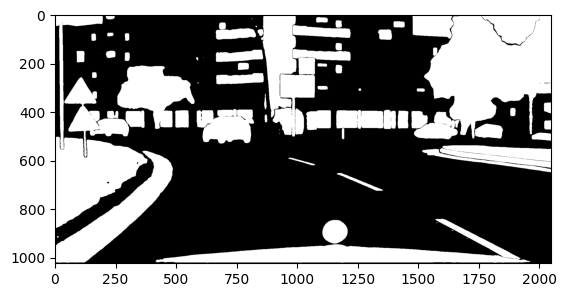

In [20]:
plt.imshow(cv2.imread(gta_input_path))